# Introduction

My friend [Andrew Key] and I are developing a series of [Data Science Challenges] to help each other and others become better Data Scientists by working on hands-on projects.

This notebook contains my work for the first challenge, _Exploring the Meetup API_ in my city of choice, beautiful **Vancouver, BC**.

## Challenge 01: Explore the Meetup API

Use the [Meetup API] to explore meetups in your city of choice.

**Guide Questions:**

Below are some guide line questions to get you started:

- What is the largest meetup in your location of choice (city, cities, country...etc)?
- How many meetups of a certain category (e.g. Tech, Art...etc) are in your city?
- Basic statistics of meetups
    - What is the average size of meetups?
    - How frequently do meetups host events?

## My guideline

I will focus on exploring the Tech Meetups in Vancouver. Specifically, I will look at the size and activity of these meetups.

As I explore the data, I will also raise additional questions that could be further explored as extensions to this project.

[//]: # (References)
[Andrew Key]: https://github.com/redpanda-ai
[Data Science Challenges]: https://johannesgiorgis.com/introducing-data-science-challenges/
[Meetup API]: https://www.meetup.com/meetup_api/

In [1]:
# import libraries

import datetime
import matplotlib.pyplot as plt
import math
import meetup.api
import os
import pandas as pd
import pprint
import requests

%matplotlib inline

Make sure you have set up **MEETUP_API_KEY** in your environment:

In _Ubuntu_:

1. Open `/etc/environment` as super user - e.g. `sudo vim /etc/environment`
2. Add `MEETUP_API_KEY="YOUR MEETUP API KEY"`
3. Open a new terminal and verify: `env | grep -i meetup`

In _MacOS_:

1. Open `~/.bash_profile`
2. Add `export MEETUP_API_KEY="YOUR MEETUP API KEY"` at the end of the file
3. Open a new terminal and verify: `env | grep -i meetup`

In [2]:
assert 'MEETUP_API_KEY' in os.environ, (
    "You need MEETUP_API_KEY in your environment"
)
client = meetup.api.Client()

---

## Helper Functions

Let's first create some helper functions.

I got the `parse_response` function from my friend Andy. Below are the explanations from his [notebook]:

This helper function helps us parse out the two most useful different pieces:

1. **meta**: an object containing meta-data about the response object itself
2. **results**: A page of actual data from the entire result of our API call



[notebook]: https://github.com/redpanda-ai/datascience_challenges/blob/master/01_explore_meetup_api/explore_sf_meetups.ipynb

In [3]:
def parse_response(response):
    '''returns two dataframes, meta and results:
        - meta: a vertically aligned dataframe, where each row is an element
            of the response.meta dictionary
        - results: a horizontally aligned dataframe, where each column is
            an element of the response.results dictionary'''
    meta = pd.DataFrame.from_dict(response.meta, orient='index')
    results = pd.DataFrame.from_dict(response.results)
    return (meta, results)

---

## Categories

When getting Meetup groups via the [GetGroups] method, we need to provide a category id.

Let's find out the different categories and their IDs:

[GetGroups]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetGroups

In [4]:
categories_resp = client.GetCategories()

29/30 (10 seconds remaining)


In [5]:
categories_meta_df, categories_df = parse_response(categories_resp)

In [6]:
categories_meta_df

,0
next,
method,Categories
total_count,33
link,https://api.meetup.com/2/categories
count,33
description,Returns a list of Meetup group categories
lon,None
title,Categories
url,https://api.meetup.com/2/categories?offset=0&f...
id,


We observe there are 33 Meetup categories.

### How the Meetup API works¶

Let's use this opportunity to understand the Meetup API via looking at the `next` field in the metadata.

Meetup API v2 response payloads are returned in pages, one at a time. Each page by default returns 200 objects. If there is more than 1 page of responses, the metadata will provide the URI for the next API call in the sequence via the `next` field. We can take advantage of this to promgrammatically get each subsequent page until we get all the objects we are looking for.

In the above metadata, since there are only 33 categories (`total_count` is 33), they are all returned in the first page. Therefore, the `next` field is empty as there is no need for any subsequent API calls to get more data.

In [7]:
categories_df

,id,name,shortname,sort_name
0,1,Arts & Culture,Arts,Arts & Culture
1,18,Book Clubs,Book Clubs,Book Clubs
2,2,Career & Business,Business,Career & Business
3,3,Cars & Motorcycles,Auto,Cars & Motorcycles
4,4,Community & Environment,Community,Community & Environment
5,5,Dancing,Dancing,Dancing
6,6,Education & Learning,Education,Education & Learning
7,8,Fashion & Beauty,Fashion,Fashion & Beauty
8,9,Fitness,Fitness,Fitness
9,10,Food & Drink,Food & Drink,Food & Drink


We see the 33 categories which each have an ID, name, short name and a sort name.

---

## Explore Cities

I am interested in exploring Meetup groups based in Vancouver, BC. To specify a specific location, the [GetGroups] method requires we specify the _country/state/city, latitude+longitude, or zip code_.

The parameters that interest us are the following from the GetGroups method:

- **city** – A valid country code, city and for the US, State. limits the returned groups to those within radius miles
- **country** – A valid country code, city and for the US, State. limits the returned groups to those within radius miles
- **lat** – A valid latitude and longitude, limits the returned groups to those within radius miles
- **lon** – A valid latitude and longitude, limits the returned groups to those within radius miles
- **zip** – A valid US zip code, limits the returned groups to those within radius miles.

I want to use the _city_ and _country_ parameters, but I am not sure what the API considers a **valid country code**. 

Let's use the [GetCities] method to figure this out. I will use 'Canada' as the country, representing country code and 'Vancouer' as the query, representing the search term.

[GetGroups]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetGroups
[GetCities]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetCities

In [8]:
cities_resp = client.GetCities(country='Canada', query='Vancouver')

28/30 (10 seconds remaining)


In [9]:
cities_meta_df, cities_df = parse_response(cities_resp)

In [10]:
cities_meta_df

,0
next,
method,Cities
total_count,2
link,https://api.meetup.com/2/cities
count,2
description,Returns Meetup cities. This method supports se...
lon,None
title,Cities
url,https://api.meetup.com/2/cities?offset=0&query...
id,


In [11]:
cities_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,Vancouver,ca,857064,49.279999,Canada,-123.040001,39959,"Vancouver, British Columbia, Canada",0,BC,V5K 0A1
1,Vancouver,us,98660,45.639999,USA,-122.680000,4699,"Vancouver, Washington, USA",1,WA,98660


**Observation**:

Our query returned 2 Vancouvers - one based in Canada another in the USA. So the country code used was not valid. 

But from our results, we can see the correct country code is **ca**. Let's verify this.

In [12]:
cities_resp = client.GetCities(country='ca', query='Vancouver')
cities_meta_df, cities_df = parse_response(cities_resp)
cities_df

27/30 (10 seconds remaining)


,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,Vancouver,ca,857064,49.279999,Canada,-123.040001,39959,"Vancouver, British Columbia, Canada",0,BC,V5K 0A1


Now we have found the correct country code and verified we are getting the one city that interests us.

---

## Explore Groups

We now have the following information and are ready to get Tech Meetup groups based in Vancouver, BC:

- category_id: we will be focusing on Tech Meetups so we will use the id 34
- city: Vancouver
- country: ca
 

In [13]:
# searching for Vancouver, Canda tech groups
groups_resp = client.GetGroups(category_id=34, city='Vancouver', country='ca')
groups_meta_df, groups_df = parse_response(groups_resp)
groups_meta_df

26/30 (10 seconds remaining)


,0
next,https://api.meetup.com/2/groups?country=ca&off...
method,Groups
total_count,433
link,https://api.meetup.com/2/groups
count,200
description,None
lon,-123.04
title,Meetup Groups v2
url,https://api.meetup.com/2/groups?country=ca&off...
id,


**Observations**

From the response's metadata, we observe that there are 433 Tech Meetup groups in Vancouver, BC. Per the explanation earlier, we only got 200 groups in this response.

Let's build a function to get all groups. This function was adapted from my friend Andy's [notebook]:


[notebook]: https://github.com/redpanda-ai/datascience_challenges/blob/master/01_explore_meetup_api/explore_sf_meetups.ipynb

In [14]:
def get_all_groups_as_df(category_id=34, city='Vancouver', country='ca'):
    '''returns all groups as a dataframe'''
    
    groups_df_list = []
    page_number = 0
    next_page = None
    
    while next_page != '':
        groups_resp = client.GetGroups(category_id=34, city='Vancouver', country='ca', offset=page_number)
        next_page = groups_resp.meta['next']
        _, group_df = parse_response(groups_resp)
        
        groups_df_list.append(group_df)
        page_number += 1
    
    return pd.concat(groups_df_list, ignore_index=True)

In [15]:
groups_df = get_all_groups_as_df()
groups_df.shape

25/30 (8 seconds remaining)
24/30 (7 seconds remaining)
23/30 (6 seconds remaining)


(433, 22)

We successfully got all 433 Tech Meetup groups by checking the size of our dataframe against the `total_count` from the response's metadata.

Time to explore :)

### Side Bar

As a side bar, let's look at an example of a group in its raw json format. The `pprint.pprint()` function is a great way of showing JSON/Python Dictionaries:

In [16]:
pprint.pprint(groups_resp.results[0])

{'category': {'id': 34, 'name': 'tech', 'shortname': 'tech'},
 'city': 'Vancouver',
 'country': 'CA',
 'created': 1034097731000,
 'description': '<p><span>The Vancouver Blogger Meetup Group is a platform '
                'where blogger and social media professionals and enthusiasts '
                'interact and network. This platform aims to be a reference '
                'and provide valuable information to graduates, professionals, '
                'small and medium sized businesses.&nbsp;<br><br>We are '
                'currently working on revitalizing this MeetUp Group and will '
                'soon bring up some topics for Meetups. Please, join our group '
                'and feel free to contact us at any time. Stay '
                'tuned!&nbsp;<br><br>Thank you and enjoy!</span></p>',
 'group_photo': {'base_url': 'https://secure.meetupstatic.com',
                 'highres_link': 'https://secure.meetupstatic.com/photos/event/2/4/f/f/highres_438549471.jpeg',
        

### Back to our DataFrame

Let's explore our dataframe.

In [17]:
groups_df.columns

Index(['category', 'city', 'country', 'created', 'description', 'group_photo',
       'id', 'join_mode', 'lat', 'link', 'lon', 'members', 'name', 'organizer',
       'rating', 'state', 'timezone', 'topics', 'urlname', 'utc_offset',
       'visibility', 'who'],
      dtype='object')

In [18]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 22 columns):
category       433 non-null object
city           433 non-null object
country        433 non-null object
created        433 non-null int64
description    433 non-null object
group_photo    238 non-null object
id             433 non-null int64
join_mode      433 non-null object
lat            433 non-null float64
link           433 non-null object
lon            433 non-null float64
members        433 non-null int64
name           433 non-null object
organizer      432 non-null object
rating         433 non-null float64
state          433 non-null object
timezone       433 non-null object
topics         433 non-null object
urlname        433 non-null object
utc_offset     433 non-null int64
visibility     433 non-null object
who            433 non-null object
dtypes: float64(3), int64(4), object(15)
memory usage: 74.5+ KB


In [19]:
groups_df.head(5)

,category,city,country,created,description,group_photo,id,join_mode,lat,link,...,name,organizer,rating,state,timezone,topics,urlname,utc_offset,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,...,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,BC,Canada/Pacific,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,-28800000,public,Friends
1,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1036650741000,"<p>Hello Everyone,</p> \n<p>My name is Nathan ...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,...,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,BC,Canada/Pacific,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,-28800000,public,Future Moguls
2,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,...,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,BC,Canada/Pacific,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,-28800000,public,Software Developers
3,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,...,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,BC,Canada/Pacific,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,-28800000,public,Vancouver Web Design Meetup
4,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,...,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,BC,Canada/Pacific,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,-28800000,public,Ruby Developers


In [43]:
# explore the uniqueness of each column's values
def display_columns_unique_values(df):
    '''display each columns unique values
        - if only 1, will display it
        - if unable to get unique values, will display data structure type
    '''
    for column in df.columns:

        try:
            unique_values = df[column].unique()
            num_unique_values = len(unique_values)
            result = f"Column {column.upper():>15}: {num_unique_values:}"

            if num_unique_values == 1:
                result += f"|Unique values: {unique_values}"

            print(result)

        # some columns contain dict objects which aren't hashable so they are ignored
        except TypeError as tp:
            print(f"Column {column.upper()}: Type: {type(df[column][0])}")
            pass

In [21]:
display_columns_unique_values(groups_df)

Column CATEGORY: Type: <class 'dict'>
Column            CITY: 11
Column         COUNTRY: 1|Unique values: ['CA']
Column         CREATED: 433
Column     DESCRIPTION: 433
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 433
Column       JOIN_MODE: 2
Column             LAT: 22
Column            LINK: 433
Column             LON: 35
Column         MEMBERS: 343
Column            NAME: 433
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 67
Column           STATE: 1|Unique values: ['BC']
Column        TIMEZONE: 2
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 433
Column      UTC_OFFSET: 1|Unique values: [-28800000]
Column      VISIBILITY: 3
Column             WHO: 194


In [22]:
groups_df['timezone'].unique()

array(['Canada/Pacific', 'America/Vancouver'], dtype=object)

**Observations**:

Our dataframe has 22 columns. We could drop a few columns.

A few columns contain only 1 unique value: `country` ('CA'), `state` ('BC') and `utc_offset` (representing UTC-8). Let's go ahead and drop these columns.

An additional column (`timezone`) only has 2 values which essentially represent the same information. Let's also drop this column.

In [23]:
groups_df = groups_df.drop(columns=['country', 'state', 'utc_offset', 'timezone'])

In [24]:
groups_df.shape

(433, 18)

In [25]:
groups_df.columns

Index(['category', 'city', 'created', 'description', 'group_photo', 'id',
       'join_mode', 'lat', 'link', 'lon', 'members', 'name', 'organizer',
       'rating', 'topics', 'urlname', 'visibility', 'who'],
      dtype='object')

In [26]:
groups_df.head(5)

,category,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,-123.129997,652,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,public,Friends
1,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1036650741000,"<p>Hello Everyone,</p> \n<p>My name is Nathan ...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,-123.120003,1867,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,public,Future Moguls
2,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6942,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
3,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4994,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
4,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,-123.110001,2626,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,public,Ruby Developers


In [27]:
display_columns_unique_values(groups_df)

Column CATEGORY: Type: <class 'dict'>
Column            CITY: 11
Column         CREATED: 433
Column     DESCRIPTION: 433
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 433
Column       JOIN_MODE: 2
Column             LAT: 22
Column            LINK: 433
Column             LON: 35
Column         MEMBERS: 343
Column            NAME: 433
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 67
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 433
Column      VISIBILITY: 3
Column             WHO: 194


**Observations**:

Now that we've done a little bit of clean up, let's look at the remaining 18 columns.

- `city`: it's interesting that there are 11 unique cities. We should look into this.
- Several columns match the size of our data so these columns contain values unique to each group
    - `created`
    - `description`
    - `id`
    - `link`
    - `name`
    - `urlname`
- 4 columns contain either lists or dictionaries. We'd have to do some more parsing if we were to explore these columns.
    - `category`
    - `group_photo`
    - `organier`
    - `topics`

- `lat` and `lon` columns: We could explore these to see if we could do any map plotting to see where groups are mainly based.
- `join_mode`: We could look into the different join modes and how many groups use one versus the other
- `members` & `ratings`: we could look into the distribution of members and ratings across the different groups
    - do more highly rated meetup groups tend to have more members?
- `visibility`: We could see how visible groups tend to be
- `who`: We could see how many Tech Groups have the same or similar target group

Beween looking at the small portion of our dataframe, the columns, and the raw JSON format of one group, we can start to understand our data a little bit more. This also helps us come up with more questions, areas to explore.

### 11 Cities in 1 City?

We observed 11 unique cities in the `city` column. This should have only been 1 city as we specified 'Vancouver' in our Meetup GetGroups method earlier.

Let's explore these:

In [28]:
groups_df['city'].unique()

array(['Vancouver', 'Langley', 'Surrey', 'North Vancouver', 'Burnaby',
       'Port Moody', 'New Westminster', 'Richmond', 'West Vancouver',
       'Port Coquitlam', 'Coquitlam'], dtype=object)

So meetups which are not strictly located in Vancouver are also returned. Looking more closely at the _city_ parameter for the GetGroups method:

- city – A valid country code, city and for the US, State. limits the returned groups to those within radius miles
- radius – Radius, in miles for geographic requests, default 25 – maximum 100

So here we understand that the method will return groups within _radius_ miles which is set as 25 miles by default. So the 433 Tech Meetup groups we got are actually based within 25 miles of Vancouver, BC and spread across 11 cities.

Let's explore how many Tech meetups are based in each city:

In [33]:
groups_df.groupby(by='city').count()

,category,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
city,,,,,,,,,,,,,,,,,
Burnaby,7,7,7,3,7,7,7,7,7,7,7,7,7,7,7,7,7
Coquitlam,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Langley,5,5,5,1,5,5,5,5,5,5,5,5,5,5,5,5,5
New Westminster,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
North Vancouver,8,8,8,2,8,8,8,8,8,8,8,8,8,8,8,8,8
Port Coquitlam,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Port Moody,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2
Richmond,3,3,3,1,3,3,3,3,3,3,3,3,3,3,3,3,3
Surrey,9,9,9,5,9,9,9,9,9,9,9,9,9,9,9,9,9


Over 90% (90.76%) of Tech Meetups are based in the city of Vancouver. Coming second, Surrey has 9 Tech Meetups.

**NOTE**: A quick Google search for 'Vancouver to Surrey' shows it is a ~33.8 km by car. So it is very likely we aren't covering the full distance of Surrey or even the whole Metro/[Greater Vancouver]. We could do further validation by increasing the radius of our search from the default 25 miles.

As the purpose of this project is to look at Tech Meetups in the city of Vancouver, we can disregard the groups which are based in other cities.

Before disregarding, let's check the largest Tech Meetups by members:

[Greater Vancouver]: https://en.wikipedia.org/wiki/Greater_Vancouver

In [40]:
groups_df.sort_values('members', ascending=False).head(20)

,category,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
173,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1448718394000,<p>TechVancouver brings together Vancouver's t...,{'highres_link': 'https://secure.meetupstatic....,19162038,open,49.279999,https://www.meetup.com/TechVancouverOrg/,-123.040001,8778,TechVancouver,"{'member_id': 14219538, 'name': 'Alexander Nor...",4.78,"[{'urlkey': 'softwaredev', 'name': 'Software D...",TechVancouverOrg,public,Technologists
2,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6942,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
60,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1347316761000,<p><b>WHY ATTEND TECH SOCIALS?</b> Simple. To ...,{'highres_link': 'https://secure.meetupstatic....,4869742,open,49.279999,https://www.meetup.com/HackerNestVAN/,-123.120003,6710,HackerNest Vancouver Tech Socials,"{'member_id': 77652922, 'name': 'HackerNest', ...",4.75,"[{'urlkey': 'softwaredev', 'name': 'Software D...",HackerNestVAN,public,HackerNesters
98,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1389135143000,<p><b>What is Cowork &amp; Coffee?</b></p>\n<p...,{'highres_link': 'https://secure.meetupstatic....,11908342,open,49.279999,https://www.meetup.com/codecoffeeyvr/,-123.139999,6296,Code & Coffee (Vancouver),"{'member_id': 8906905, 'name': 'Jenn Cooper', ...",4.65,"[{'urlkey': 'opensource', 'name': 'Open Source...",codecoffeeyvr,public,Developers
137,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1422291923000,<p>Startup Founder 101 brings together aspirin...,{'highres_link': 'https://secure.meetupstatic....,18381330,open,49.279999,https://www.meetup.com/Vancouver-Startup-Found...,-123.040001,5766,Vancouver Startup Founder 101,"{'member_id': 11314237, 'name': 'Jonathan Gree...",4.58,"[{'urlkey': 'webdesign', 'name': 'Web Design',...",Vancouver-Startup-Founder-101,public,Aspiring Founders
16,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1263596978000,<p>Meeting the right people is crucial. We loo...,{'highres_link': 'https://secure.meetupstatic....,1583286,open,49.279999,https://www.meetup.com/Vancouver-Tech-Co-Found...,-123.110001,5112,Vancouver Pixel Crafters,"{'member_id': 11767095, 'name': 'Hussein Halla...",4.62,"[{'urlkey': 'softwaredev', 'name': 'Software D...",Vancouver-Tech-Co-Founders,public,Entrepreneurs
3,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4994,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
23,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1273291070000,<p>Vancouver is home to many game developers a...,{'highres_link': 'https://secure.meetupstatic....,1642334,open,49.270000,https://www.meetup.com/Vancouver-Indie-Game-De...,-123.120003,4825,Full Indie,"{'member_id': 2874080, 'name': 'Andrew Hamilto...",4.61,"[{'urlkey': 'gamedev', 'name': 'Game Developme...",Vancouver-Indie-Game-Developers,public,Indies
193,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1462151582000,<p>We invite startup leaders and experts to sh...,{'highres_link': 'https://secure.meetupstatic....,19905099,open,49.259998,https://www.meetup.com/YVR-Startups/,-123.139999,4714,YVR Startups,"{'member_id': 41331852, 'name': 'Ed', 'photo':...",4.67,"[{'urlkey': 'webdesign', 'name': 'Web Design',...",YVR-Startups,public,Entrepr

The top 20 largest Tech Meetups by number of members are all based in Vancouver. So we can drop the non-Vancouver based Tech Meetups without it affecting our original question of exploring group's number of members and activities.

In [47]:
vancouver_tech_groups = groups_df[groups_df['city'] == 'Vancouver']

In [48]:
vancouver_tech_groups.shape

(393, 18)

In [49]:
vancouver_tech_groups.head(5)

,category,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,-123.129997,652,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,public,Friends
1,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1036650741000,"<p>Hello Everyone,</p> \n<p>My name is Nathan ...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,-123.120003,1867,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,public,Future Moguls
2,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6942,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
3,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4994,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
4,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,-123.110001,2626,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,public,Ruby Developers


In [50]:
display_columns_unique_values(vancouver_tech_groups)

Column CATEGORY: Type: <class 'dict'>
Column            CITY: 1|Unique values: ['Vancouver']
Column         CREATED: 393
Column     DESCRIPTION: 393
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 393
Column       JOIN_MODE: 2
Column             LAT: 9
Column            LINK: 393
Column             LON: 20
Column         MEMBERS: 322
Column            NAME: 393
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 66
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 393
Column      VISIBILITY: 3
Column             WHO: 185


In [51]:
# drop the city column
vancouver_tech_groups = vancouver_tech_groups.drop(columns=['city'])

### Tech Meetup Members

Let's explore the distribution of members across Tech Meetups in Vancouver.

In [55]:
vancouver_tech_groups['members'].describe()

count     393.000000
mean      681.374046
std      1107.604436
min         1.000000
25%        86.000000
50%       295.000000
75%       698.000000
max      8778.000000
Name: members, dtype: float64

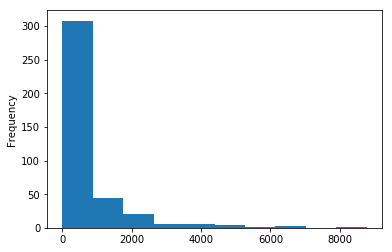

In [62]:
vancouver_tech_groups['members'].plot.hist()

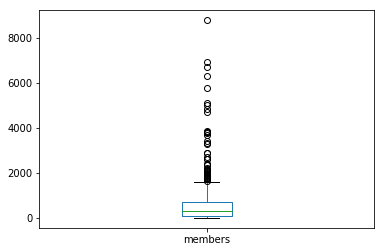

In [56]:
vancouver_tech_groups['members'].plot.box()

In [64]:
vancouver_tech_groups['members'].value_counts(bins = 10, normalize=True).sort_index(ascending=False) * 100

(7900.3, 8778.0]                 0.254453
(7022.6, 7900.3]                 0.000000
(6144.9, 7022.6]                 0.763359
(5267.2, 6144.9]                 0.254453
(4389.5, 5267.2]                 1.017812
(3511.8, 4389.5]                 1.272265
(2634.1, 3511.8]                 1.526718
(1756.4, 2634.1]                 5.343511
(878.7, 1756.4]                 11.195929
(-7.7780000000000005, 878.7]    78.371501
Name: members, dtype: float64

**Observations**:

From the descriptive statistics table that the `describe()` function provides us, we observe:

- average number of members is 681
- There is/are meetups with 1 member
- The largest meetup has 8778 members
- The median meetup member size is 295

Our histogram is a very rightly skewed plot, further demonstrating how most Tech Meetups have members in the 100's and not 1000's.

The box plot shows the large number of outliers. What is interesting is that there are a few clusters of outliers around the 2000 - 4000, another cluster around ~5000 and the rest spread out a bit more until we get to out largest group of 8778 members.

Lastly, the custom frequency table shows us that:

- almost **90%** of Tech Meetups have 1756 members or less, with a majority of these having less than 878
- Around **~9%** of Tech Meetups have between 1756 and 5267 members.